<a href="https://colab.research.google.com/github/emrapport/w266-final-project/blob/master/final_model_error_analysis_ER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Error analysis of final model



In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import time
import pickle
!pip install gcsfs

pd.set_option('max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [0]:
# this cell is only necessary if running in colab
project_id = 'w266-251323'
import uuid
bucket_name = 'fb-congressional-data/'
from google.colab import auth
auth.authenticate_user()
!gcloud config set project {project_id}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Updated property [core/project].


In [0]:
# Load the test data and predictions
dev_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/dev.csv", index_col=0)
test_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/test.csv", index_col=0)
dev_preds = pd.read_csv("gs://fb-congressional-data/models/dev_preds.csv")
test_preds = pd.read_csv("gs://fb-congressional-data/models/test_preds.csv")
dev_preds_party = pd.read_csv("gs://fb-congressional-data/models/dev_preds_party.csv")
test_preds_party = pd.read_csv("gs://fb-congressional-data/models/test_preds_party.csv")
test_preds_party = pd.read_csv("gs://fb-congressional-data/models/test_preds_party.csv")



/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
print(test_df.op_gender.value_counts())
test_df.op_gender.value_counts()[0] / test_df.shape[0]

M    1434429
W     260155
Name: op_gender, dtype: int64


0.8464785457669847

In [0]:
test_preds_party.head()

,original_idx,probs_party,preds_party
0,9225551,0.384,Congress_Republican
1,7514285,0.545,Congress_Democrat
2,6128273,0.401,Congress_Republican
3,6370382,0.327,Congress_Republican
4,8962461,0.462,Congress_Republican


In [0]:
dev_preds.head()

,original_idx,probs,preds
0,2210805,0.288,M
1,10316428,0.254,M
2,5297343,0.252,M
3,5030266,0.294,M
4,4918178,0.176,M


In [0]:
dev_preds_party.head()


,original_idx,probs_party,preds_party
0,2210805,0.654,Congress_Democrat
1,10316428,0.457,Congress_Republican
2,5297343,0.353,Congress_Republican
3,5030266,0.544,Congress_Democrat
4,4918178,0.144,Congress_Republican


In [0]:
# Correct the "democratic" party prediction to match op party (haven't executed this cell yet)
dev_preds_party.loc[dev_preds_party['preds_party']=='Congress_Democrat', 'preds_party'] = 'Congress_Democratic'
test_preds_party.loc[test_preds_party['preds_party']=='Congress_Democrat', 'preds_party'] = 'Congress_Democratic'


In [0]:
test_df = test_df.merge(test_preds,on='original_idx')
test_df = test_df.merge(test_preds_party,on='original_idx')
test_df.head()

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
0,1682766,78379937,W,21367,Tonia,jacky thank you for addressing this very troubling news! please demand a full independent invest...,Jacky Rosen,Congress_Democratic,0.287,M,0.567,Congress_Democratic
1,1682767,78379937,W,21367,Michancy,agreed! the russian connection to this administration must be fully investigated. flynn is the ...,Jacky Rosen,Congress_Democratic,0.150,M,0.439,Congress_Republican
2,1682768,78379937,W,21367,Andrea,please push chaffez and cummings to look into this!,Jacky Rosen,Congress_Democratic,0.203,M,0.509,Congress_Democratic
3,1682769,78379937,W,21367,Tina,i could not agree more!,Jacky Rosen,Congress_Democratic,0.229,M,0.371,Congress_Republican
4,1682770,78379937,W,21368,Cathy,"i imagine that is followed by ""when qualifited.""",Jacky Rosen,Congress_Democratic,0.276,M,0.354,Congress_Republican


In [0]:
dev_df = dev_df.merge(dev_preds,on='original_idx')
dev_df = dev_df.merge(dev_preds_party,on='original_idx')
dev_df.head()

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
0,1965080,86681682,M,29909,James,thanks for passing this ridiculous legislation. https://www.youtube.com/watch?v=-y4wd8royre,Jim Banks,Congress_Republican,0.208,M,0.391,Congress_Republican
1,1965081,86681682,M,29909,Martha,handsome young man on the left. 😂 mom,Jim Banks,Congress_Republican,0.258,M,0.436,Congress_Republican
2,1965082,86681682,M,29911,Preston,you are sideways!,Jim Banks,Congress_Republican,0.365,M,0.484,Congress_Republican
3,1965083,86681682,M,29911,Bobby,hi congressman banks,Jim Banks,Congress_Republican,0.036,M,0.493,Congress_Republican
4,1965084,86681682,M,29911,Landon,"jim, i love your office. the 5th floor is for winners.",Jim Banks,Congress_Republican,0.048,M,0.546,Congress_Democratic


In [0]:
wrong_preds = test_df[test_df.op_gender!=test_df.preds]


In [0]:
wrong_preds.op_gender.value_counts()

W    219299
M     36790
Name: op_gender, dtype: int64

In [0]:
# total proportion of preds for women
dev_df.preds.value_counts()['W'] / len(dev_df)

0.03995132955674003

In [0]:
#random sample of mistakes
wrong_preds.sample(10)

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
288995,4100810,72264613,W,146041,Kristopher,nasa= need another seven astronauts,Kyrsten Sinema,Congress_Democratic,0.252,M,0.328,Congress_Republican
305374,4118285,72264613,W,147586,Judy,"yeah, one of the few places in the world where a monsoon is only a dust storm and high humidity ...",Kyrsten Sinema,Congress_Democratic,0.274,M,0.460,Congress_Republican
279247,3507780,33093506,W,115222,Debra,why is funding amnesty more important than funding the rest of dhs? vote yes on the next proced...,Tammy Baldwin,Congress_Democratic,0.171,M,0.029,Congress_Republican
1382756,13446206,64366485,W,515967,Nancy,"I am just curious then, why did rudy guiliani say trump asked him for a muslim ban? http://the...",Claudia Tenney,Congress_Republican,0.203,M,0.683,Congress_Democratic
686209,8891355,3162230,W,304417,Tom,how about a clean vote kristi...?? ever think about doing that instead of going online and tryi...,Kristi Noem,Congress_Republican,0.247,M,0.421,Congress_Republican
901761,9285720,61839194,M,327555,Ellie,you are so inspiring <3 so glad that you are my senator.,Cory Booker,Congress_Democratic,0.759,W,0.825,Congress_Democratic
733992,8967554,4804331,W,310400,Eric,sweet. way to get some investment in chicago. our city could really use the ... wait... we do ...,Cheri Bustos,Congress_Democratic,0.281,M,0.612,Congress_Democratic
726989,8960214,4804331,W,310005,Bradley,"i asked this once before and I am asking it again. the congress claims to generate $14 billion, ...",Cheri Bustos,Congress_Democratic,0.236,M,0.266,Congress_Republican
670204,8874802,3162230,W,303982,Jeff,"randee: if there were anything that could prove that rounds did anything wrong, the obama polit...",Kristi Noem,Congress_Republican,0.179,M,0.681,Congress_Democratic
708556,8914269,3162230,W,305463,Gary,"december 27, 2008- gov. mike rounds (r) plans to draw down $26 million in reserve funds to balan...",Kristi Noem,Congress_Republican,0.233,M,0.241,Congress_Republican


In [0]:
# most confident wrong predictions where true was M but prediction was W
wrong_preds.sort_values('probs', ascending=False)[:20]

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
362434,6096572,39064513,M,209578,Sue,"thank you, bernie. thank you, jill. thank you, tulsi. thank you to all the veterans. and a s...",Earl Blumenauer,Congress_Democratic,1.000,W,1.000,Congress_Democratic
933902,9321039,61839194,M,327804,Kenneth,"hey kamala, i voted for you because of the great work you have done for the environmental justic...",Cory Booker,Congress_Democratic,1.000,W,1.000,Congress_Democratic
933563,9320679,61839194,M,327804,Judy,go kamala. win!,Cory Booker,Congress_Democratic,1.000,W,1.000,Congress_Democratic
933715,9320844,61839194,M,327804,Kristina,i love and appreciate all three of you! kamala has all five of our votes!!👍,Cory Booker,Congress_Democratic,1.000,W,0.999,Congress_Democratic
381625,6116832,39064513,M,210160,Claudia,what is tulsi doing in portland ? she is hawaii's congresswoman. doing a wonderful job.,Earl Blumenauer,Congress_Democratic,1.000,W,1.000,Congress_Democratic
860437,9240975,61839194,M,327395,Cindy,thank you patty murray. i knew i voted for you for a good reason.,Cory Booker,Congress_Democratic,1.000,W,1.000,Congress_Democratic
933860,9320995,61839194,M,327804,Lynn,kamala will be a most wonderful addition to the us senate..heart thanks for hair support...💌,Cory Booker,Congress_Democratic,1.000,W,1.000,Congress_Democratic
926925,9313361,61839194,M,327789,Ralph,"good job corey, better job patty for keeping your hand on the pulse of america.",Cory Booker,Congress_Democratic,1.000,W,0.994,Congress_Democratic
857375,9237795,61839194,M,327395,Ann,i <3 patty murray. and you. thank you. i <3 wa state.,Cory Booker,Congress_Democratic,1.000,W,0.999,Congress_Democratic
933573,9320689,61839194,M,327804,John,"stay close to them, kamala--that has the future.",Cory Booker,Congress_Democratic,1.000,W,0.999,Congress_Democratic


In [0]:
# most confident wrong predictions where true was W but predicted M
wrong_preds.sort_values('probs', ascending=True)[:20]

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
633199,7607197,47811014,W,292581,Mark,if angus votes for him angus will lose my vote next cycle.,Chellie Pingree,Congress_Democratic,0.000,M,0.197,Congress_Republican
667404,8871902,3162230,W,303890,Joelle,vote gohmert! and remember you are there for america not just sd. very disappointed you voted fo...,Kristi Noem,Congress_Republican,0.000,M,0.000,Congress_Republican
75588,2337351,98470558,W,50839,Katie,go louie :),Elise Stefanik,Congress_Republican,0.000,M,0.001,Congress_Republican
681997,8887071,3162230,W,304367,Carl,it would seem you are an old hand at dealing with clowns like that. keep up the good fight sir!,Kristi Noem,Congress_Republican,0.000,M,0.163,Congress_Republican
638638,7612806,47811014,W,292642,Kathy,we must be sure to let rep. poliquin know that we are watching how he votes on this.,Chellie Pingree,Congress_Democratic,0.000,M,0.000,Congress_Republican
638455,7612619,47811014,W,292641,Ren,"so, just wondering is rep poliquin going to vote against obama care and strip 75,000 mainers fr...",Chellie Pingree,Congress_Democratic,0.000,M,0.005,Congress_Republican
353324,5928285,15083367,W,201408,Heather,"you do realize you only won by 5.8 %. start doing your job, show up and listen to your constitue...",Barbara Comstock,Congress_Republican,0.000,M,0.000,Congress_Republican
642983,7617345,47811014,W,292986,Sam,"sending good thoughts, angus!",Chellie Pingree,Congress_Democratic,0.000,M,0.107,Congress_Republican
289660,4101545,72264613,W,146140,Don,"what a phony you are! I am so proud of my rep, ruben gallego.",Kyrsten Sinema,Congress_Democratic,0.000,M,0.998,Congress_Democratic
1391273,13695821,83604908,W,534896,Susie,"tennant out this time, carper out the next time. shelley has my vote. jim ballard",Shelley Moore Capito,Congress_Republican,0.000,M,0.962,Congress_Democratic


In [0]:
# Least confident predictions.

least_conf = test_df[(test_df.probs<0.50005) & (test_df.probs>0.49995)]

In [0]:
# Incorrect low confidence predictions.
least_conf[least_conf.op_gender!=least_conf.preds].sort_values(by='probs')


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
339155,5797921,62031614,W,191300,Jen,seriously? unemployment is at 5% and the stock market is still at a all time high .... actions a...,Jackie Walorski,Congress_Republican,0.500,M,0.431,Congress_Republican
296202,4108647,72264613,W,146797,Michael,it must be an election year. the prada socialist ( her words) claiming to be for the good sheepl...,Kyrsten Sinema,Congress_Democratic,0.500,M,0.255,Congress_Republican
290034,4101964,72264613,W,146192,William,"omg, I am agreeing with ms. sinema.",Kyrsten Sinema,Congress_Democratic,0.500,M,0.652,Congress_Democratic
860607,9241152,61839194,M,327395,Ann,some are so hung up on the abortion issue that they ignore all the other issues of women's health,Cory Booker,Congress_Democratic,0.500,W,0.515,Congress_Democratic
1413104,13822951,8879946,M,540664,Kristen,what if the breast cancer patient is on medicaid?,Bill Cassidy,Congress_Republican,0.500,W,0.554,Congress_Democratic
423770,6320227,67504140,M,233105,Kesha,hagan knows we all now how she misused that stimulus for her personal use! crime,Thom Tillis,Congress_Republican,0.500,W,0.354,Congress_Republican
214771,3098496,42138413,M,81676,Loretta,we need more senators like you. wish you were here in florida,Tim Scott,Congress_Republican,0.500,W,0.579,Congress_Democratic
975392,10019419,41098373,M,364679,Kerry,i am proud that my congressional representative dwight evans joined john lewis and others in boy...,Dwight Evans,Congress_Democratic,0.500,W,0.992,Congress_Democratic
984541,11114055,10284504,M,391015,Carol,proud of our west salem girl!,Ron Kind,Congress_Democratic,0.500,W,0.464,Congress_Republican
1162129,12270735,18759563,M,458809,Milton,"actually, tom cotton did not violate the logan act which applies to private citizens negotiating...",Tom Cotton,Congress_Republican,0.500,W,0.625,Congress_Democratic


In [0]:
# Correct low confidence predictions.
least_conf[least_conf.op_gender==least_conf.preds].sort_values(by='probs')


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
165660,3046932,42138413,M,80946,Brigitte,"happy mother's day to your mother, a strong woman!",Tim Scott,Congress_Republican,0.500,M,0.649,Congress_Democratic
784959,9160751,61839194,M,327345,Nicky,"as the parent of an amazing daughter with special needs, i want to thank you from the bottom of ...",Cory Booker,Congress_Democratic,0.500,M,0.587,Congress_Democratic
360042,6094104,39064513,M,209554,Jeannette,"thank you for your words about the hero john lewis. and, for your stand in boycotting the inaugu...",Earl Blumenauer,Congress_Democratic,0.500,M,0.996,Congress_Democratic
774333,9149525,61839194,M,327340,Giselle,"thank you for calling this out, senator booker! she had the right to read this letter!",Cory Booker,Congress_Democratic,0.500,M,0.598,Congress_Democratic
783367,9159119,61839194,M,327342,Betty,yeah well i am still deeply upset that you sold out to pharma...,Cory Booker,Congress_Democratic,0.500,M,0.745,Congress_Democratic
182677,3064882,42138413,M,81170,Betty,what fine men their mother did something great when she raised them.,Tim Scott,Congress_Republican,0.500,M,0.386,Congress_Republican
543695,7484818,65473098,M,288121,Jonn,"we tried and look what they did to us in michigan to keep it off the ballot,sorry but we should ...",Thomas Massie,Congress_Republican,0.500,M,0.566,Congress_Democratic
431961,6328802,67504140,M,233157,BillandKay,yes let us move her out,Thom Tillis,Congress_Republican,0.500,M,0.325,Congress_Republican
421992,6318375,67504140,M,233095,John,what would she do if thom tillis walked in? run and hide again?,Thom Tillis,Congress_Republican,0.500,M,0.302,Congress_Republican
104725,2981803,42138413,M,80121,Roseanne,"i am a south carolinian and a retired professor, educated through the public school system. bets...",Tim Scott,Congress_Republican,0.500,M,0.291,Congress_Republican


proportion of responses that have this word: 0.018

\bman\b
count   28422.000
mean        0.151
std         0.124
min         0.000
25%         0.064
50%         0.134
75%         0.203
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.021

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when man is present: 0.110
how often model gets it wrong overall: 0.178


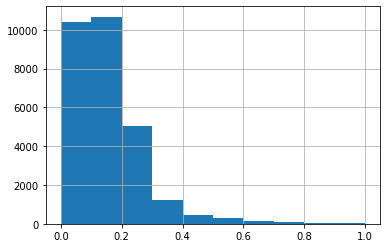

In [0]:
print_word = "man"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.005

\bwoman\b
count   8065.000
mean       0.451
std        0.232
min        0.000
25%        0.273
50%        0.436
75%        0.607
max        1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.398

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when woman is present: 0.352
how often model gets it wrong overall: 0.178


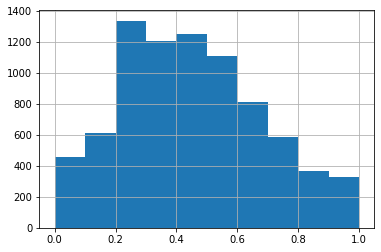

In [0]:
print_word = "woman"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.019

\blove\b
count   30174.000
mean        0.292
std         0.189
min         0.000
25%         0.172
50%         0.279
75%         0.376
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.107

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when love is present: 0.201
how often model gets it wrong overall: 0.178


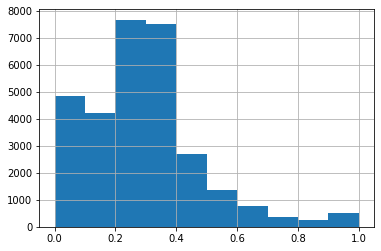

In [0]:
print_word = "love"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.003

\bamazing\b
count   5035.000
mean       0.313
std        0.193
min        0.000
25%        0.200
50%        0.286
75%        0.390
max        1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.144

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when amazing is present: 0.235
how often model gets it wrong overall: 0.178


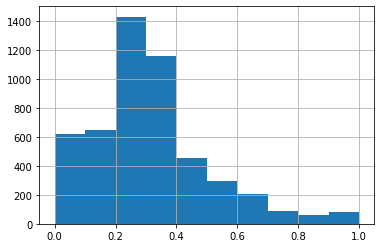

In [0]:
print_word = "amazing"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.006

\bstrong\b
count   9854.000
mean       0.240
std        0.179
min        0.000
25%        0.140
50%        0.227
75%        0.299
max        1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.065

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when strong is present: 0.163
how often model gets it wrong overall: 0.178


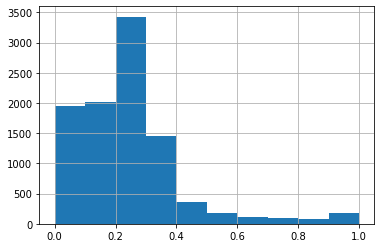

In [0]:
print_word = "strong"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.003

\bplanned parenthood\b
count   4429.000
mean       0.360
std        0.174
min        0.000
25%        0.251
50%        0.351
75%        0.457
max        0.999
Name: probs, dtype: float64
proportion of responses where we predict W: 0.178

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when planned parenthood is present: 0.270
how often model gets it wrong overall: 0.178


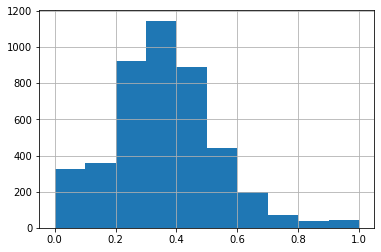

In [0]:
print_word = "planned parenthood"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.00006

\bkamala\b
count   95.000
mean     0.866
std      0.259
min      0.024
25%      0.925
50%      0.987
75%      0.997
max      1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.863

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when kamala is present: 0.800
how often model gets it wrong overall: 0.178


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
494999,6412939,76094169,M,241643,Diane,"thank you, senator whitehouse! i am waiting to hear the same from my own senators, senator diane...",Sheldon Whitehouse,Congress_Democratic,0.024,M,1.000,Congress_Democratic
95845,2972496,42138413,M,80101,Frank,"do i trust these senators to do anything? no. republicans richard burr, north carolina, chairm...",Tim Scott,Congress_Republican,0.093,M,0.552,Congress_Democratic
800682,9177594,61839194,M,327362,Kala,"thank you, cory! i wrote to the white house today and also to kamala harris to lend my time and ...",Cory Booker,Congress_Democratic,0.137,M,0.543,Congress_Democratic
270464,3498555,33093506,W,114291,Rebecca,trump/russian hacking & senate investigation: http://www.chicagotribune.com/news/nationworld/ct...,Tammy Baldwin,Congress_Democratic,0.220,M,0.777,Congress_Democratic
1419573,13829819,8879946,M,541560,Linda,"actually, I had like to know more about the group that did the filming, and find out if they bro...",Bill Cassidy,Congress_Republican,0.231,M,0.176,Congress_Republican
802819,9179854,61839194,M,327362,Chris,corey - you think you are left? no you are not - you are a centrist with some left tendencies an...,Cory Booker,Congress_Democratic,0.239,M,0.393,Congress_Republican
824732,9203068,61839194,M,327383,Florencia,"senator booker, i think that for the same reason that you thought it harmless, essentially, to v...",Cory Booker,Congress_Democratic,0.244,M,0.568,Congress_Democratic
933751,9320885,61839194,M,327804,Lisa,"our homes are homes are being stolen #wallstcrime while our officials are taking selfies, i want...",Cory Booker,Congress_Democratic,0.247,M,0.554,Congress_Democratic
93969,2619057,19770004,W,64457,Tracey,"although those are good reasons to question the electoral vote, there is one other reason that h...",Barbara Lee,Congress_Democratic,0.267,M,0.358,Congress_Republican
100763,2977645,42138413,M,80109,Aaron,"america, democrats, republicans, independents, libertarians, green partiers, and others, remembe...",Tim Scott,Congress_Republican,0.294,M,0.357,Congress_Republican


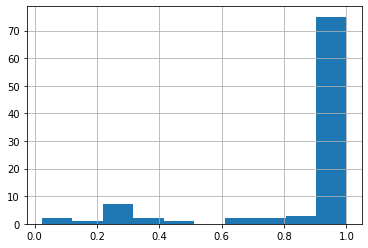

In [0]:
print_word = "kamala"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))
word_preds.sort_values('probs', ascending=True)[:20]

Interesting that congressman and congresswoman seem to be way better signals to the model of addressing a poster of a certain gender, compared to man vs woman

proportion of responses that have this word: 0.01686

\bcongressman\b
count   26915.000
mean        0.049
std         0.097
min         0.000
25%         0.006
50%         0.014
75%         0.037
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.008

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when congressman is present: 0.031
how often model gets it wrong overall: 0.178


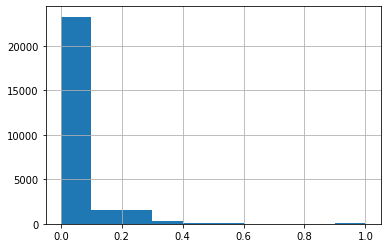

In [0]:
print_word = "congressman"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.00334

\bcongresswoman\b
count   5324.000
mean       0.887
std        0.236
min        0.004
25%        0.941
50%        0.988
75%        0.998
max        1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.897

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when congresswoman is present: 0.108
how often model gets it wrong overall: 0.178


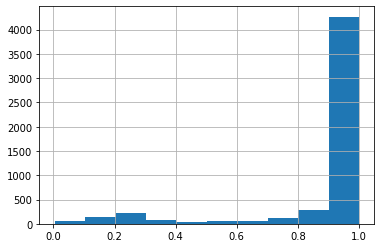

In [0]:
print_word = "congresswoman"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.00268

\bmother\b
count   4270.000
mean       0.315
std        0.173
min        0.000
25%        0.212
50%        0.295
75%        0.392
max        1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.122

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when mother is present: 0.246
how often model gets it wrong overall: 0.178


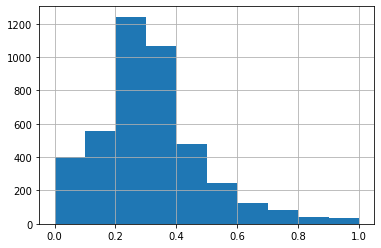

In [0]:
print_word = "mother"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

"Her": is intersting - model seems to have learned it as strong signal for female, but it's wrong a lot of the time. Way more than "his" is wrong. Same thing with "she"

proportion of responses that have this word: 0.02058

\bher\b
count   32854.000
mean        0.431
std         0.223
min         0.000
25%         0.266
50%         0.417
75%         0.568
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.351

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when her is present: 0.357
how often model gets it wrong overall: 0.178


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
933624,9320746,61839194,M,327804,Cee,i voted for kamala in the primary and will be voting for her again in november!,Cory Booker,Congress_Democratic,0.999,W,1.000,Congress_Democratic
861069,9241643,61839194,M,327395,Betty,you are standing with a newly elected representative of new hampshire. former governor maggie ha...,Cory Booker,Congress_Democratic,0.999,W,0.997,Congress_Democratic
933696,9320824,61839194,M,327804,Ellen,a friend of cory booker is a friend of mine though i cannot vote for her because i do not live i...,Cory Booker,Congress_Democratic,0.999,W,0.999,Congress_Democratic
516602,7079591,98302075,M,265965,Steven,jessica haha patty murray pretty much put her in her place!,Mark Pocan,Congress_Democratic,0.998,W,0.993,Congress_Democratic
933847,9320982,61839194,M,327804,Cathleen,thank you! I am a huge supporter of kamala harris and I am happy to see you supporting her. sh...,Cory Booker,Congress_Democratic,0.997,W,1.000,Congress_Democratic
467756,6366213,21956266,M,233488,Glenn,"ben, on this, let the people see and say what they think. how about you get behind mia love and ...",Ben Sasse,Congress_Republican,0.995,W,0.001,Congress_Republican
579908,7523458,65473098,M,288674,Marie,"i see that, true to her nature, lynn jenkins voted for it.",Thomas Massie,Congress_Republican,0.995,W,0.001,Congress_Republican
1228812,12344789,18759563,M,458996,Michelle,"daniel murray, I am glad you know so much about the congressman's personal life. maybe we need t...",Tom Cotton,Congress_Republican,0.995,W,0.938,Congress_Democratic
546318,7487646,65473098,M,288147,Searching,gabbard is one of very few democrats i respect even if i do not fully agree with her stances,Thomas Massie,Congress_Republican,0.994,W,0.974,Congress_Democratic
36731,2004506,60229427,M,31116,Barb,"i sent the letter & got the response i expected.basically patty thinks it is wonderful.wow, i se...",John Thune,Congress_Republican,0.994,W,0.988,Congress_Democratic


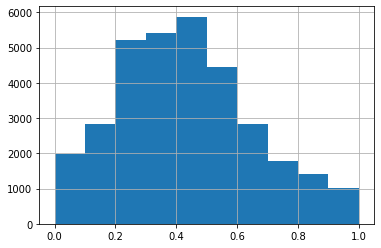

In [0]:
print_word = "her"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))
word_wrong_preds.sort_values('probs', ascending=False)[:20]

proportion of responses that have this word: 0.04330

\bhis\b
count   69118.000
mean        0.182
std         0.113
min         0.000
25%         0.124
50%         0.170
75%         0.221
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.020

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when his is present: 0.135
how often model gets it wrong overall: 0.178


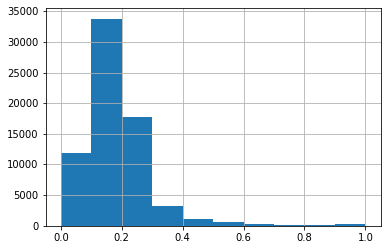

In [0]:
print_word = "his"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.02306

\bshe\b
count   36811.000
mean        0.452
std         0.216
min         0.000
25%         0.296
50%         0.450
75%         0.583
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.396

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when she is present: 0.379
how often model gets it wrong overall: 0.178


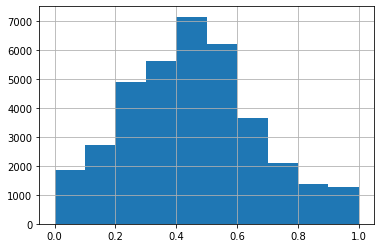

In [0]:
print_word = "she"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.04260

\bsenator\b
count   67991.000
mean        0.234
std         0.168
min         0.000
25%         0.110
50%         0.230
75%         0.324
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when senator is present: 0.092
how often model gets it wrong overall: 0.178


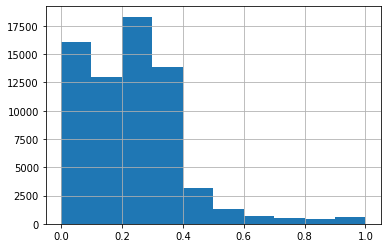

In [0]:
print_word = "senator"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.00000

\bhis\b
count   0.000
mean      nan
std       nan
min       nan
25%       nan
50%       nan
75%       nan
max       nan
Name: probs, dtype: float64


ZeroDivisionError: ignored

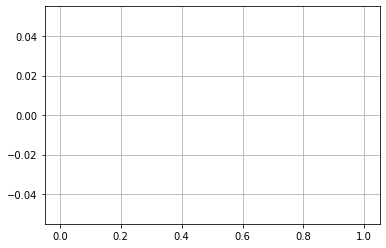

In [0]:
print_word = "his"
word = r"\b{}\b".format(print_word)
word_preds = test_df[test_df['response_text']==word]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))